In [2]:
pip install numpy 

  Using cached numpy-1.19.2-cp38-cp38-macosx_10_9_x86_64.whl (15.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np

In [7]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import seaborn as sns

In [9]:
import pandas
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)
  
#read from google drive
data=pandas.read_csv("conversion_project.csv")
  
print(data.head())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0


In [10]:
print(data.describe(include="all"))

       country            age       new_user  source  total_pages_visited      converted
count   316200  316200.000000  316200.000000  316200        316200.000000  316200.000000
unique       4            NaN            NaN       3                  NaN            NaN
top         US            NaN            NaN     Seo                  NaN            NaN
freq    178092            NaN            NaN  155040                  NaN            NaN
mean       NaN      30.569858       0.685465     NaN             4.872966       0.032258
std        NaN       8.271802       0.464331     NaN             3.341104       0.176685
min        NaN      17.000000       0.000000     NaN             1.000000       0.000000
25%        NaN      24.000000       0.000000     NaN             2.000000       0.000000
50%        NaN      30.000000       1.000000     NaN             4.000000       0.000000
75%        NaN      36.000000       1.000000     NaN             7.000000       0.000000
max        NaN     12

In [11]:
print(data.groupby(['country']).size())

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64


In [12]:
print(data.groupby(['source']).size())

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64


In [13]:
print(data[data['age']>110])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


In [14]:
data = data[data['age']<110]

<AxesSubplot:xlabel='country'>

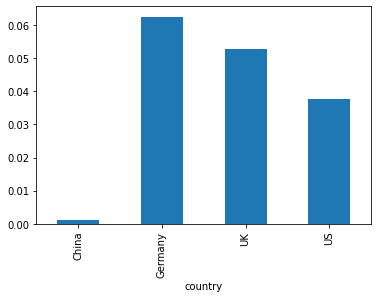

In [15]:
data.groupby(['country'])['converted'].mean().plot.bar()

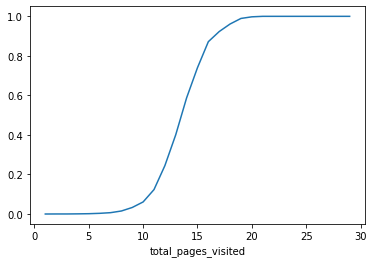

In [16]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.show()

In [17]:
data_dummy =  pandas.get_dummies(data, drop_first=True)

In [18]:
data_dummy.head()

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1
3,39,1,5,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,1


In [19]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [21]:
np.random.seed(4684)
  
#split into train and test to avoid overfitting
train, test = train_test_split(data_dummy, test_size = 0.34)

In [22]:
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1),train['converted'])

RandomForestClassifier(max_features=3, oob_score=True)

In [23]:
rf.oob_score_

0.9838851885571901

In [24]:
pandas.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))

,0,1
0,200872,1102
1,2261,4455


In [25]:
rf.score(test.drop('converted', axis=1),test['converted'])

0.9847360196450496

In [26]:
pandas.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))

,0,1
0,103483,543
1,1098,2384


<AxesSubplot:>

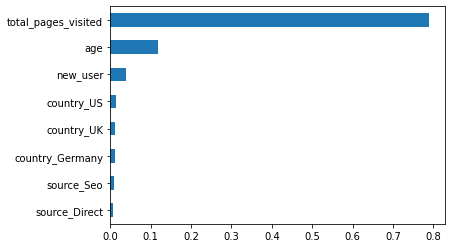

In [28]:
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')

In [32]:
#build the model without total_pages_visited
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.889827016148354 
 OOB Confusion Matrix 
         0      1
0  182720  19254
1    3738   2978


In [33]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)


Test accuracy is 0.8899802805372623 
 Test Set Confusion Matrix 
        0     1
0  94140  9886
1   1942  1540


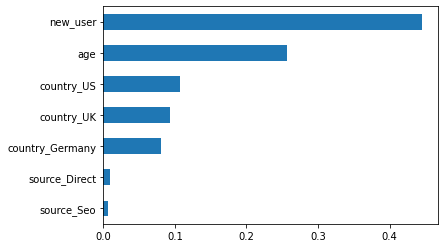

In [34]:
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

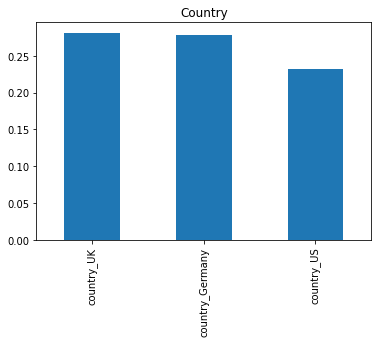

In [38]:
from pdpbox import pdp, info_plots
  
#country
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

In [46]:
data.groupby('country').size()

country
China       76602
Germany     13055
UK          48449
US         178092
dtype: int64

In [48]:
data[data['converted']==1].groupby('country').size()/data.groupby('country').size()

country
China      0.001332
Germany    0.062428
UK         0.052612
US         0.037801
dtype: float64

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='Country'>})

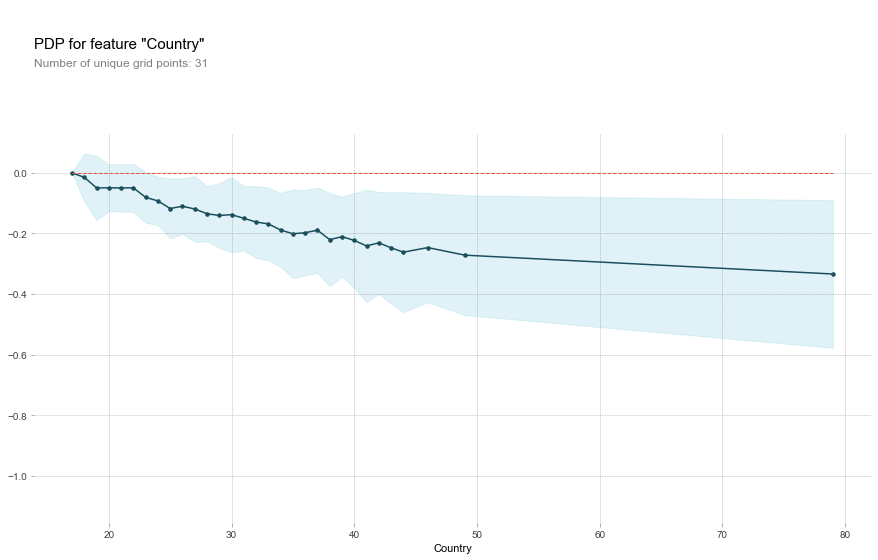

In [42]:
pdp.pdp_plot(pdp_iso, 'Country')

In [36]:
pdp_dataset

country_Germany    0.278174
country_UK         0.281307
country_US         0.232185
dtype: float64

In [37]:
list(train.drop(['converted', 'total_pages_visited'], axis=1))

['age',
 'new_user',
 'country_Germany',
 'country_UK',
 'country_US',
 'source_Direct',
 'source_Seo']

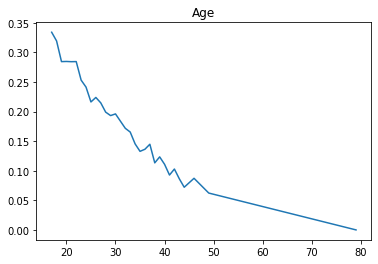

In [41]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='Age'>})

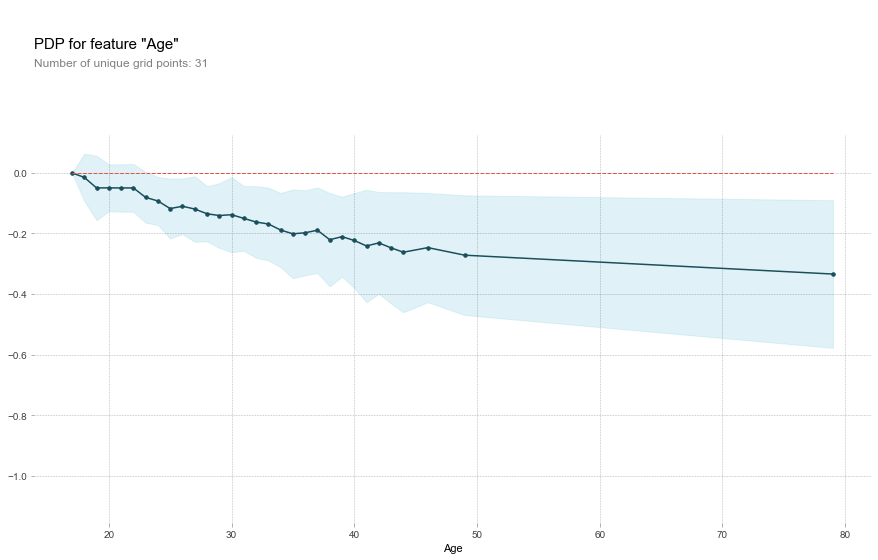

In [43]:
pdp.pdp_plot(pdp_iso, 'Age')